# Encoder decoder without Attention.

In this problem, we will generate sequences of random integers as input and matching output sequences comprised of a subset of the integers in the input sequence. For example, an input sequence might be [1, 6, 2, 7, 3] and the expected output sequence might be the first two random integers in the sequence [1, 6].We will define the problem such that the input and output sequences are the same length and pad the output sequences with “0” values as needed. Next we need to One Hot encode.

In [1]:
import numpy as np
from random import randint
from keras.utils import to_categorical

# generate a sequence of random integers
def generate_sequence(length, n_unique):
    return [randint(0, n_unique-1) for _ in range(length)]

def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]

Using TensorFlow backend.


In [2]:
# prepare data for the LSTM
def get_pair(n_in, n_out, n_unique):
    '''
    Generates a random sequence of data of length n_in
    and an output sequence of length n_out based in the input.
    And padds the rest of the sequence with 0 if they don't have
    the same size.
    Then converts to categorical
    '''
    # generate random sequence for input and output
    sequence_in = generate_sequence(n_in, n_unique)
    sequence_out = sequence_in[:n_out] + [0 for _ in range(n_in-n_out)]
    # one hot encode
    X = to_categorical(sequence_in, n_unique)
    y = to_categorical(sequence_out, n_unique)
    # reshape as 3D for the RNN.
    # Dimensions: (Samples, time_steps, features)
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y

In [3]:
# generate random sequence
X, y = get_pair(5, 2, 50)
print('Samples, time_steps, features')
print(X.shape, y.shape)
print('X=%s, y=%s' % (one_hot_decode(X[0]), one_hot_decode(y[0])))

Samples, time_steps, features
(1, 5, 50) (1, 5, 50)
X=[26, 20, 45, 45, 7], y=[26, 20, 0, 0, 0]


Now let's create a baseline of the problem using Encoder-Decoder without Attention. We can develop a simple encoder-decoder model in Keras by taking the output from an encoder LSTM model, repeating it `n` times for the number of timesteps in the output sequence, then using a decoder to predict the output sequence.

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense

# configure problem
n_features = 50
n_timesteps_in = 5
n_timesteps_out = 2

# define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=150, input_shape=(n_timesteps_in, n_features)))
model.add(tf.keras.layers.RepeatVector(n_timesteps_in))
model.add(tf.keras.layers.LSTM(units=150, return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(Dense(n_features, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               120600    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 150)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 150)            180600    
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 50)             7550      
Total params: 308,750
Trainable params: 308,750
Non-trainable params: 0
_________________________________________________________________


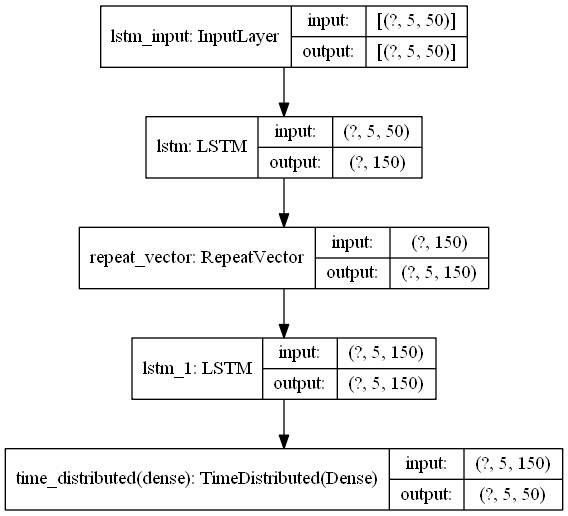

In [6]:
from IPython.display import HTML
from keras.utils.vis_utils import plot_model, model_to_dot
# this is for making Graphviz work (plot_model needs GraphViz)
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=96)

In [50]:
# train LSTM
def one_step_train(model):
    # We will train the model on 1,000 random 
    # input-output pairs of integer sequences.
    for epoch in range(2000):
        # generate new random sequence
        X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
        # fit model for one epoch on this sequence
        model.fit(X, y, epochs=1, verbose=0)
    return model

model = one_step_train(model)

Once trained, we will evaluate the model on 100 new randomly generated integer sequences and only mark a prediction correct when the entire output sequence matches the expected value.

In [51]:
# evaluate LSTM
total, correct = 100, 0
for _ in range(total):
    X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
    yhat = model.predict(X, verbose=0)
    if np.array_equal(one_hot_decode(y[0]), one_hot_decode(yhat[0])):
        correct += 1
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))
# spot check some examples
for _ in range(10):
    X,y = get_pair(n_timesteps_in, n_timesteps_out, n_features)
    yhat = model.predict(X, verbose=0)
    print('Expected:', one_hot_decode(y[0]), 'Predicted', one_hot_decode(yhat[0]))

Accuracy: 36.00%
Expected: [28, 21, 0, 0, 0] Predicted [28, 21, 0, 0, 0]
Expected: [2, 37, 0, 0, 0] Predicted [2, 2, 0, 0, 0]
Expected: [8, 11, 0, 0, 0] Predicted [8, 39, 0, 0, 0]
Expected: [6, 30, 0, 0, 0] Predicted [6, 30, 0, 0, 0]
Expected: [28, 11, 0, 0, 0] Predicted [28, 28, 0, 0, 0]
Expected: [29, 22, 0, 0, 0] Predicted [29, 29, 0, 0, 0]
Expected: [13, 18, 0, 0, 0] Predicted [13, 18, 0, 0, 0]
Expected: [42, 6, 0, 0, 0] Predicted [42, 42, 0, 0, 0]
Expected: [19, 37, 0, 0, 0] Predicted [19, 37, 0, 0, 0]
Expected: [5, 33, 0, 0, 0] Predicted [8, 8, 0, 0, 0]


We can see from the sample outputs that the model does get one number in the output sequence correct for most or all cases, and only struggles with the second number. All zero padding values are predicted correctly.